In [ ]:
# Pytorch is typically already installed in Google Colab (uncomment to install):
# !pip install torch==1.8.0
# or for GPU support:
# !pip install torch==1.8.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers==4.27.0
!pip install datasets==2.10.0
# NLTK is typically also already installed in Google Colab (uncomment to install):
# !pip install nltk==3.8.1

## Download NMT data

We first download the data for NMT, which contains pairs of parallel sentences.

In [ ]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a4/resources.zip
!unzip -qo resources.zip

In [ ]:
from datasets import load_from_disk
raw_text_datasets = load_from_disk("resources/parallel_en_fr_corpus")
print("Summary of splits:", raw_text_datasets)
print("First training example:", raw_text_datasets["train"][0])

Summary of splits: DatasetDict({
    train: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 8701
    })
    validation: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 485
    })
    test: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 486
    })
})
First training example: {'text_en': 'i m tough .', 'text_fr': 'je suis dure .'}


In [ ]:
from transformers import AutoTokenizer
source_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_fr")
target_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_en")

print("Vocab size of source language:", source_tokenizer.vocab_size)
print("Vocab size of target language:", target_tokenizer.vocab_size)

# As a demonstration, we will the following English sentence to tokens.
example_sentence = "we have an example"
tokenizer_output = target_tokenizer(example_sentence)
print("\n*** Example ***")
print("Example sentence:", example_sentence)
print("Tokenizer output:", tokenizer_output)

# We convert every token id to its associated string, but find the special character ▁ which indicates the beginning of a word.
# Note that very common words are represented by a single token, while others are split into subunits due to the small vocab size.
# Also note that †he tokenizer already adds special tokens to the beginning and end of the sentence.
decoded_sequence = [target_tokenizer.decode(token) for token in tokenizer_output["input_ids"]]
print("Tokens:", decoded_sequence)

# By replacing the special character ▁ with whitespace, we can reconstruct a legibile sentence,
# which differs from the original example by special tokens, includings <unk> tokens, and minor whitespace differences.
reconstructed = "".join(decoded_sequence).replace("▁", " ")
print("Reconstructed sentence", reconstructed)

Vocab size of source language: 3200
Vocab size of target language: 3200

*** Example ***
Example sentence: we have an example
Tokenizer output: {'input_ids': [1, 64, 324, 103, 266, 1490, 92, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Tokens: ['<s>', '▁we', '▁have', '▁an', '▁ex', 'amp', 'le', '</s>']
Reconstructed sentence <s> we have an example</s>


In [ ]:
from typing import Dict, List

def map_example(example: Dict[str, str]) -> Dict[str, List[int]]:
    # TODO: Tokenize the source and target text for an entry in the parallel dataset
    # and return a dictionary with the keys "encoder_input_ids" and "decoder_input_ids".
    # You can use `source_tokenizer` and `target_tokenizer`

    # Tokenize the source and target text for an entry in the parallel dataset
    encoder_input_ids = source_tokenizer.encode(example["text_fr"])
    decoder_input_ids = target_tokenizer.encode(example["text_en"])
    # Clamp the target language input ids to ensure they fall within the valid range
    max_index = target_tokenizer.vocab_size - 1
    decoder_input_ids = [min(token_id, max_index) for token_id in decoder_input_ids]

    return {"encoder_input_ids": encoder_input_ids, "decoder_input_ids": decoder_input_ids}

# When mapped is applied to the DatasetDict object, it will apply `map` separately to each split.
tokenized_datasets = raw_text_datasets.map(map_example, batched=False)

# The `remove_columns` removes the existing text features from the new dataset, as they are no longer needed.
tokenized_datasets = tokenized_datasets.remove_columns(raw_text_datasets.column_names["train"])

# Sanity checks on the new dataset
assert set(tokenized_datasets.column_names["train"]) == {"decoder_input_ids", "encoder_input_ids"}
assert len(tokenized_datasets["train"]) == len(raw_text_datasets["train"])

Map:   0%|          | 0/8701 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/486 [00:00<?, ? examples/s]

## Transformer model for NMT

We will now implement a encoder-decoder transformer model.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from typing import Optional, Dict, List, Tuple

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 num_attention_heads: int,
                 is_causal_attention: bool = False,
                 is_cross_attention: bool = False):
        """Defines a flexible multi-head attention layer.

        This layer should define parameters for the query, key and value projections, as well as the output projection,
        and implement the following steps:
        (1) Project the input vectors using query projection and key projection matrices.
        (2) Compute the head-wise attention scores scaled by 1/sqrt(head_dim)
        (3) Perform appropriate masking to the attention scores using key_padding_mask and optionally causal attention.
        (4) Normalize the head-wise attention scores using softmax.
        (5) Compute the value projections and then aggregate using the normalized attention scores.
        (6) Use the output projection to obtain the final output vectors.
        When is_cross_attention is True, the key and value projections are computed from the encoder outputs.
        Note that we do not use attention weight dropout in this implementation.

        Args:
            hidden_size: The dimensionality of the input vectors.
            num_attention_heads: The number of attention heads.
            is_causal_attention: Whether to use causal masking,
                    where tokens cannot attend to the future tokens on their right.
            is_cross_attention: Whether to use cross attention,
                    where we use different inputs for the key/value vs. query vectors.
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        assert hidden_size % num_attention_heads == 0, "The hidden size must be divisible by the number of attention heads."
        self.head_dim = hidden_size // num_attention_heads  # embedding dimension of query and key vectors per head
        self.is_causal_attention = is_causal_attention
        self.is_cross_attention = is_cross_attention

        # Initialize query, key, and value projection matrices
        self.query_proj = nn.Linear(hidden_size, hidden_size)
        self.key_proj = nn.Linear(hidden_size, hidden_size)
        self.value_proj = nn.Linear(hidden_size, hidden_size)

        # Initialize output projection matrix
        self.output_projection = nn.Linear(hidden_size, hidden_size)

        # Initialize additional parameters for causal attention
        if is_causal_attention:
            self.causal_mask = self.causal_attention_mask(hidden_size)
        else:
            self.causal_mask = None

         # Initialize additional parameters for cross attention
        if self.is_cross_attention:
            self.encoder_query_proj = nn.Linear(hidden_size, hidden_size)
            self.encoder_key_proj = nn.Linear(hidden_size, hidden_size)
            self.encoder_value_proj = nn.Linear(hidden_size, hidden_size)


    def causal_attention_mask(self,
                              sequence_length: int,
                              device: Optional[torch.device] = None) -> torch.FloatTensor:
        """Return a Float tensor that can be added to the (un-normalized) attention scores for causal masking.

        Args:
            sequence_length: width and height of the attention mask tensor.
            device: which torch device the resulting tensor should be on (important if you use GPU).

        Returns:
            A Float tensor of shape (1, 1, sequence_length, sequence_length) on device `device`,
            where the entries above the diagonal contain large negative values,
            which means that a query at position i can't attend to a key at position j>i.
        """

        causal_mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1)
        causal_mask = causal_mask * (-10**9)  # Use a large negative value for masking

        # If a device is specified, move the tensor to that device
        if device is not None:
            causal_mask = causal_mask.to(device)

        return causal_mask.unsqueeze(0).unsqueeze(0)


    def forward(self,
                hidden_states: torch.FloatTensor,
                key_padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Computes scaled dot-product attention and returns the output of the attention layer.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the input vectors to the layer.
            key_padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                    A `True` entry means that this token should be ignored for the purpose of attention.
                    In the case of cross-attention, the tensor has shape (batch_size, encoder_sequence_length).
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size).
                    The output vectors of the encoder and only passed if the layer performs cross-attention.

        Returns:
            A (layer_output, attention_weights) where layer_output is a tensor of shape (batch_size, sequence_length, hidden_size)
            and attention_weights are the normalized attention scores in the form of
            a tensor of shape (batch_size, num_attention_heads, number_of_query_tokens, number_of_key_tokens).
        """

        
        if self.is_cross_attention:
            query = self.encoder_query_proj(hidden_states)
            key = self.encoder_key_proj(encoder_outputs)
            value = self.encoder_value_proj(encoder_outputs)
        else:
            query = self.query_proj(hidden_states)
            key = self.key_proj(hidden_states)
            value = self.value_proj(hidden_states)

        # Split query, key, and value into multiple heads
        query = query.view(query.shape[0], query.shape[1], self.num_attention_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_attention_heads, sequence_length, head_dim)
        key = key.view(key.shape[0], key.shape[1], self.num_attention_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_attention_heads, sequence_length, head_dim)
        value = value.view(value.shape[0], value.shape[1], self.num_attention_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_attention_heads, sequence_length, head_dim)
        self.head_dim=query.shape[-1]
        # Compute scaled dot-product attention scores
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(self.head_dim)  # (batch_size, num_attention_heads, sequence_length, sequence_length)

        # Apply causal attention mask if needed
        if self.is_causal_attention:
            causal_mask = self.causal_attention_mask(hidden_states.size(1), device=hidden_states.device)
            attention_scores += causal_mask

        # Apply key padding mask
        attention_scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2),-10**9)

        # Apply softmax to obtain attention weights
        attention_weights = attention_scores.softmax(dim=-1)  # (batch_size, num_attention_heads, sequence_length, sequence_length)

        # Apply attention to values
        context = attention_weights @ value  # (batch_size, num_attention_heads, sequence_length, head_dim)

        # Concatenate attention head outputs and apply output projection
        context = context.transpose(1, 2).contiguous().view(context.shape[0], -1, self.num_attention_heads * self.head_dim)
        output = self.output_projection(context)  # (batch_size, sequence_length, hidden_size)

        return output, attention_weights

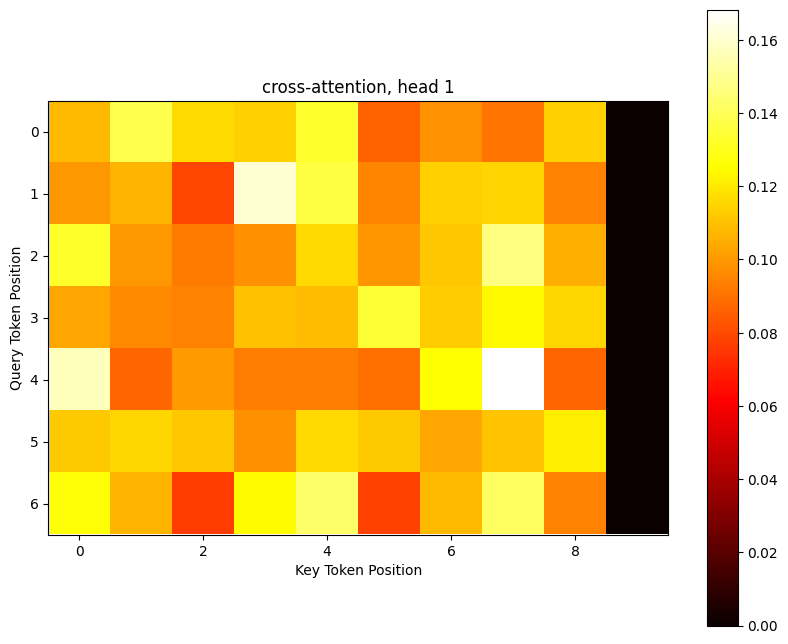

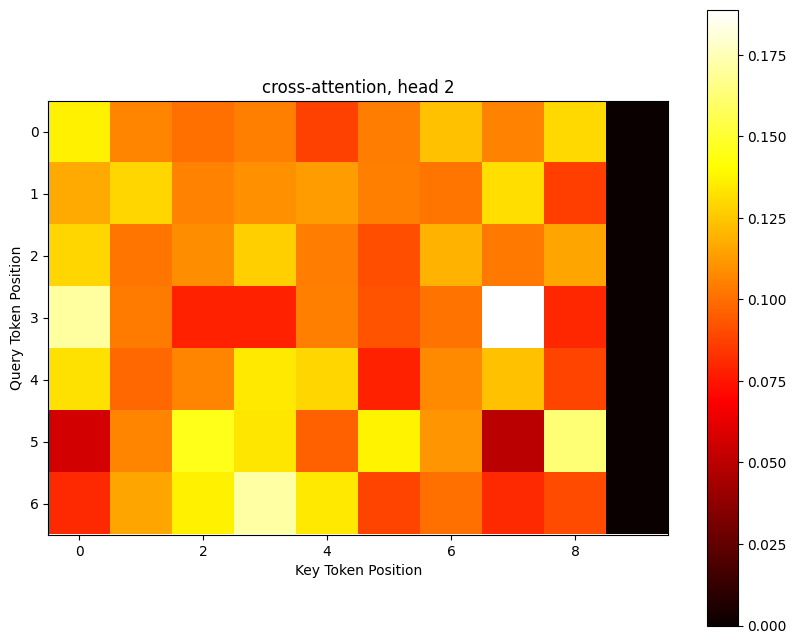

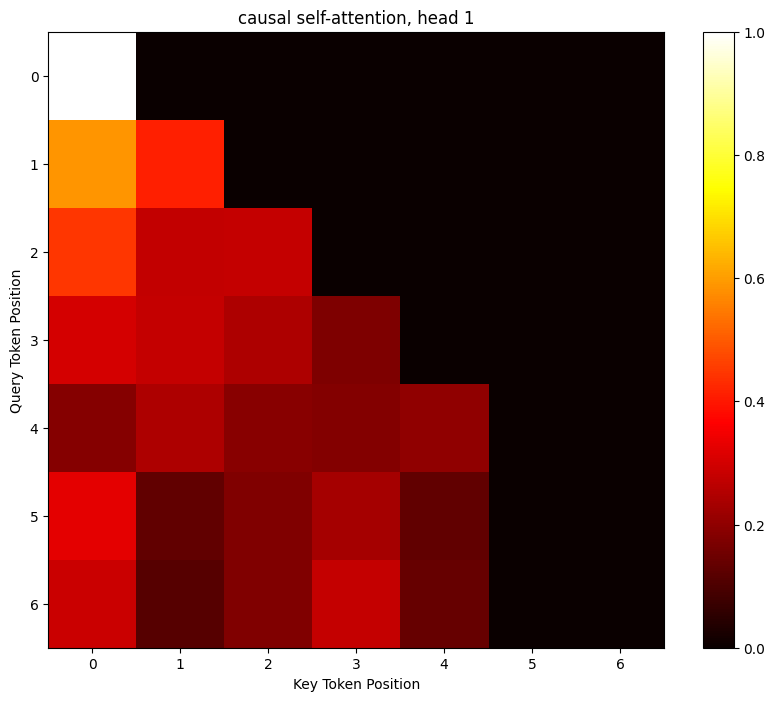

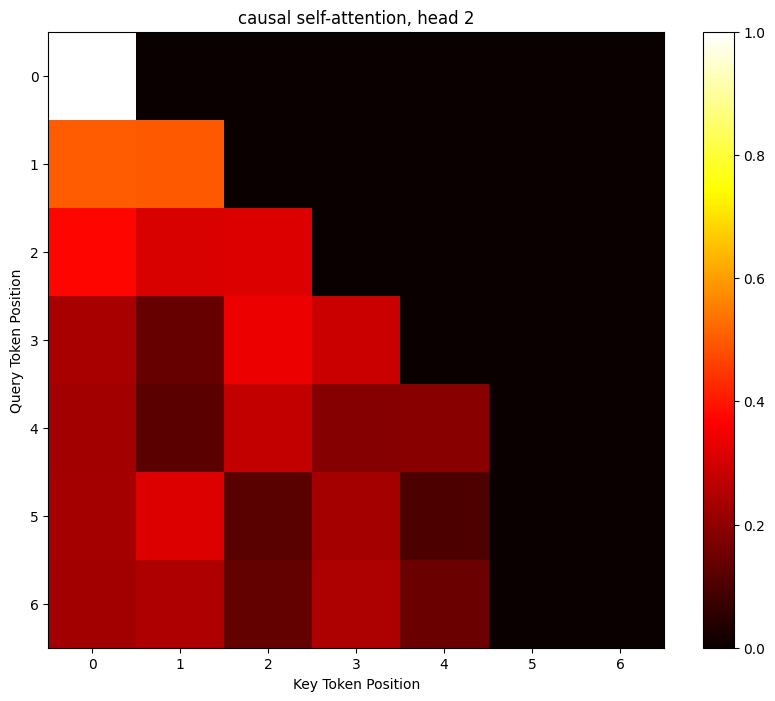

In [ ]:
embed_dim = 8
num_heads = 2
batch_size = 1
encoder_seq_length = 5
decoder_seq_length = 7

encoder_outputs = torch.randn(batch_size, encoder_seq_length, embed_dim)
decoder_inputs = torch.randn(batch_size, decoder_seq_length, embed_dim)

encoder_padding_mask = torch.zeros(batch_size, encoder_seq_length, dtype=torch.bool)
encoder_padding_mask[:, -1] = True # The last encoder token is a padding tokens

decoder_padding_mask = torch.zeros(batch_size, decoder_seq_length, dtype=torch.bool)
decoder_padding_mask[:, -2:] = True # The last two decoder tokens are padding token


cross_attention = MultiHeadAttention(embed_dim, num_heads, is_cross_attention=True)
causal_attention = MultiHeadAttention(embed_dim, num_heads, is_causal_attention=True)
cross_attention_out, cross_attention_weights = cross_attention(decoder_inputs, encoder_padding_mask, encoder_outputs)
causal_attention_out, causal_attention_weights = causal_attention(decoder_inputs, decoder_padding_mask)

# Make sure your outputs have the right shapes
assert cross_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert cross_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, encoder_seq_length)
assert causal_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)
assert causal_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, decoder_seq_length)

# Check that the attention weights are normalized
assert torch.isclose(cross_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()
assert torch.isclose(causal_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()

# Check if the attention masking works
assert torch.isclose(cross_attention_weights[:,:,:,-1], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,:,-2:], torch.tensor(0.0)).all()
assert torch.isclose(causal_attention_weights[:,:,2,3:], torch.tensor(0.0)).all()


import matplotlib.pyplot as plt

def plot_attention_matrix(attention_matrix, title):
    """Creates a new figure and plots the normalized attention weights as a heatmap.

    This should provide a colorbar for the scale of the heatmap and label the axes "query token position" and "key token position".
    Args:
        attention_matrix: A numpy array of shape (number_of_query_tokens, number_of_key_tokens)
        title: The title of the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Key Token Position')
    plt.ylabel('Query Token Position')
    plt.show()

plot_attention_matrix(cross_attention_weights[0,0].detach().numpy(), "cross-attention, head 1")
plot_attention_matrix(cross_attention_weights[0,1].detach().numpy(), "cross-attention, head 2")
plot_attention_matrix(causal_attention_weights[0,0].detach().numpy(), "causal self-attention, head 1")
plot_attention_matrix(causal_attention_weights[0,1].detach().numpy(), "causal self-attention, head 2")

In [ ]:
class TransformerEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, hidden_size: int, max_sequence_length: int):
        """Defines the embedding layer with learnt positional embeddings.

        This layer defines both the token embeddings and positional embeddings,
        which are added together to form the final embedding.

        Args:
            vocab_size: The size of the vocabulary,
                    used to define the size of the token embedding table.
            hidden_size: The dimensionality of the embedding space for both token embeddings and positional embeddings.
            max_sequence_length: The maximum sequence length of the input sequences,
                    used to define the size of the position embedding table.

        Note that this implementation does not use dropout on the embeddings
        and uses learnt positional embeddings instead of sinusoidal embeddings.
        """
        super().__init__()

        # Token Embedding Layer
        self.token_embeddings = nn.Embedding(vocab_size, hidden_size)
        self.max_sequence_length=max_sequence_length
        # Positional Embedding Layer
        self.position_embeddings = nn.Embedding(max_sequence_length, hidden_size)

    def compute_logits(self, decoder_output: torch.FloatTensor) -> torch.FloatTensor:
        """Computes the logits for the next token prediction given the decoder output.

        Args:
            decoder_output: Tensor of shape (batch_size, sequence_length, hidden_size) - the output of the decoder.

        Returns:
            Tensor of shape (batch_size, sequence_length, vocab_size) containing the logits for the next token prediction.
        """
        # Access the weight parameter matrix of the token embedding layer
        token_embedding_weights = self.token_embeddings.weight  # Shape: (vocab_size, hidden_size)
        # Compute logits by projecting the decoder output onto the token embedding weights
        logits = torch.matmul(decoder_output ,token_embedding_weights.T ) # Shape: (batch_size, sequence_length, vocab_size)

        return logits

    def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        """Computes the embeddings for the input tokens.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing
                    the sum of token embeddings and position embeddings for the input tokens.
        """

        batch_size, seq_length = input_ids.size()
        positions = torch.arange(seq_length, device=input_ids.device).unsqueeze(0).expand(batch_size, -1)
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(positions)
        return token_embeddings + position_embeddings

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 hidden_dropout_prob: float,
                 is_decoder: bool = False):
        """Defines a single Transformer block, which can be either for the encoder or the decoder.

        Args:
            hidden_size: The dimensionality of the input and output vectors of this layer.
            intermediate_size: The intermediate size of the feedforward layers.
            num_attention_heads: The number of attention heads.
            hidden_dropout_prob: The dropout probability for the hidden states.
            is_decoder: Whether this block is part of the decoder.
        """
        super().__init__()

        self.is_decoder = is_decoder
        self.self_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_causal_attention=is_decoder)
        self.self_attention_layer_norm = nn.LayerNorm(hidden_size)

        if is_decoder:
            self.cross_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_cross_attention=True)
            self.cross_attention_layer_norm = nn.LayerNorm(hidden_size)

        self.feedforward = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.ReLU(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(hidden_dropout_prob))
        self.feedforward_layer_norm = nn.LayerNorm(hidden_size)

    def forward(self,
                hidden_states: torch.FloatTensor,
                padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None,
                encoder_padding_mask: Optional[torch.BoolTensor] = None) -> torch.FloatTensor:
        """Defines a single Transformer block, either for the encoder or the decoder.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the outputs from the previous layer.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                    A `True` entry means that this token should be ignored for the purpose of attention.
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size),
                    which are the output vectors of the encoder. This argument is only used by decoder blocks.
            encoder_padding_mask: Optional tensor of shape (batch_size, encoder_sequence_length) indicating
                    which encoder tokens are padding tokens. This argument is only used in decoder blocks.
                    A `True` entry means that this token should be ignored for the purpose of attention.

        """
        hidden_states = self.self_attention(hidden_states, padding_mask)[0] + hidden_states
        hidden_states = self.self_attention_layer_norm(hidden_states)

        if self.is_decoder:
            hidden_states = self.cross_attention(hidden_states, encoder_padding_mask, encoder_outputs)[0] + hidden_states
            hidden_states = self.cross_attention_layer_norm(hidden_states)

        hidden_states = self.feedforward(hidden_states) + hidden_states
        hidden_states = self.feedforward_layer_norm(hidden_states)
        return hidden_states

In [ ]:
class EncoderDecoderModel(nn.Module):
    def __init__(self,
                 source_vocab_size: int,
                 target_vocab_size: int,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 max_sequence_length: int,
                 hidden_dropout_prob: float):
        """A encoder-decoder transformer model which can be used for NMT.

        Args:
            source_vocab_size: The size of the source vocabulary.
            target_vocab_size: The size of the target vocabulary.
            hidden_size: The dimensionality of all input and output embeddings.
            intermediate_size: The intermediate size in the feedforward layers.
            num_attention_heads: The number of attention heads in each multi-head attention modules.
            num_encoder_layers: The number of transformer blocks in the encoder.
            num_decoder_layers: The number of transformer blocks in the decoder.
            max_sequence_length: The maximum sequence length that this model can handle.
            hidden_dropout_prob: The dropout probability in the hidden state in each block.
        """

        super().__init__()

        self.source_embeddings = TransformerEmbeddings(source_vocab_size, hidden_size, max_sequence_length)
        self.target_embeddings = TransformerEmbeddings(target_vocab_size, hidden_size, max_sequence_length)
        # Encoder blocks
        self.encoder_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob,is_decoder=False)
            for _ in range(num_encoder_layers)
        ])

        # Decoder blocks
        self.decoder_blocks = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob,is_decoder=True)
            for _ in range(num_decoder_layers)
        ])
        self.max_sequence_length = max_sequence_length
        self.target_vocab_size = target_vocab_size
        # self.norm=torch.nn.LayerNorm(normalized_shape=(hidden_size,))

    def forward_encoder(self, input_ids: torch.LongTensor, padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the encoder.

        Args:
            input_ids: tensor of shape (batch_size, sequence_length) containing the input token ids to the encoder.
            padding_mask: tensor of shape (batch_size, sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing the output embeddings of the encoder.
        """

    # Forward pass through source embeddings
        encoder_embedding=self.source_embeddings(input_ids)
        for eb in self.encoder_blocks:
          encoder_embedding= eb(encoder_embedding,padding_mask)

        return encoder_embedding

    def forward_decoder(self,
                        input_ids: torch.LongTensor,
                        padding_mask: torch.BoolTensor,
                        encoder_outputs: torch.FloatTensor,
                        encoder_padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the decoder.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids to the decoder.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which decoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.
            encoder_outputs: Tensor of shape (batch_size, encoder_sequence_length, hidden_size) containing the output embeddings of the encoder.
            encoder_padding_mask: Tensor of shape (batch_size, encoder_sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in cross-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, target_vocabulary_size)
            containing the logits for predicting the next token in the target sequence.
        """

        decoder_embeddings=self.target_embeddings(input_ids)
        for db in self.decoder_blocks:
          decoder_embeddings = db(decoder_embeddings, padding_mask, encoder_outputs, encoder_padding_mask)
        logits = self.target_embeddings.compute_logits(decoder_embeddings)
        return logits

    def forward(self, encoder_input_ids, encoder_padding_mask, decoder_input_ids, decoder_padding_mask):


        encoder_outputs = self.forward_encoder(encoder_input_ids, encoder_padding_mask)
        decoder_logits = self.forward_decoder(decoder_input_ids, decoder_padding_mask, encoder_outputs, encoder_padding_mask)
        return decoder_logits




## Train the model

In this section, we train the seq2seq model on the parallel tokenized corpus.

In [ ]:
def collate_fn(examples: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
    """Collates a list of variable length sequences from the dataset into a batch of pytorch tensors with padding."""

    encoder_sequence_length = max(len(example["encoder_input_ids"]) for example in examples)
    decoder_sequence_length = max(len(example["decoder_input_ids"]) for example in examples)
    batch_size = len(examples)

    encoder_input_ids = torch.full((batch_size, encoder_sequence_length),
                                   fill_value=source_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    encoder_padding_mask = torch.ones((batch_size, encoder_sequence_length),
                                      dtype=torch.bool)

    decoder_input_ids = torch.full((batch_size, decoder_sequence_length),
                                   fill_value=target_tokenizer.pad_token_id,
                                   dtype=torch.int64)
    decoder_padding_mask = torch.ones((batch_size, decoder_sequence_length),
                                      dtype=torch.bool)

    for i, example in enumerate(examples):
        encoder_input_ids[i, :len(example["encoder_input_ids"])] = torch.tensor(example["encoder_input_ids"])
        encoder_padding_mask[i, :len(example["encoder_input_ids"])] = False

        decoder_input_ids[i, :len(example["decoder_input_ids"])] = torch.tensor(example["decoder_input_ids"])
        decoder_padding_mask[i, :len(example["decoder_input_ids"])] = False

    return {"encoder_input_ids": encoder_input_ids,
            "encoder_padding_mask": encoder_padding_mask,
            "decoder_input_ids": decoder_input_ids,
            "decoder_padding_mask": decoder_padding_mask}

In [ ]:
import time
import math

def compute_loss_per_token(model, batch):
    logits = model(**batch)
    valid_label_mask = ~(batch["decoder_padding_mask"][:,1:])
    labels = batch["decoder_input_ids"][:,1:][valid_label_mask]
    logits = logits[:,:-1][valid_label_mask]
    return F.cross_entropy(logits, labels, reduction='none')


def evaluate_perplexity(model, dataset, batch_size=32, device="cpu"):
    model.eval()

    dev_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    num_tokens = loss_sum = 0

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for batch in dev_loader:
            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)

            token_losses = compute_loss_per_token(model, batch)

            loss_sum += token_losses.sum()
            num_tokens += token_losses.numel()

        dev_ppl = (loss_sum / num_tokens).exp().cpu().item()
    return dev_ppl


def train(model, training_dataset, validation_dataset,
          batch_size=32, lr=1e-3, max_epoch=10, log_every=10, valid_niter=100,
          model_path="model.pt"):
    model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epoch = global_step = loss_sum = num_tokens = num_examples = 0
    best_valid_perplexity = float('inf')
    train_time = begin_time = time.time()
    print('Beginning maximum likelihood training')


    while True:
        train_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        epoch += 1
        batches_per_epoch = len(train_loader)
        for i, batch in enumerate(train_loader):
            global_step += 1

            # Move tensors in batch to device
            for key in batch:
                batch[key] = batch[key].to(device)

            optimizer.zero_grad()
            token_losses = compute_loss_per_token(model, batch)
            total_loss = token_losses.sum()

            loss = total_loss / batch_size
            loss.backward()

            optimizer.step()

            loss_sum += total_loss.cpu().item()
            num_tokens += token_losses.numel()
            num_examples += batch_size

            if global_step % log_every == 0:
                average_loss = loss_sum / num_examples
                average_ppl = math.exp(loss_sum / num_tokens)
                print(f"epoch {epoch} ({i}/{batches_per_epoch}) | step {global_step} | "
                      f"avg_nll={average_loss:.2f} avg_ppl={average_ppl:.2f} "
                      f"speed={num_tokens / (time.time() - train_time):.2f} words/sec "
                      f"time_elapsed={time.time() - begin_time:.2f} sec")

                train_time = time.time()
                loss_sum = num_tokens = num_examples = 0.0

            if global_step % valid_niter == 0:
                print('Begin validation ...')
                dev_perplexity = evaluate_perplexity(model, validation_dataset, batch_size=batch_size, device=device)

                print(f"validation: step {global_step} | dev_ppl={dev_perplexity}")

                if dev_perplexity < best_valid_perplexity:
                    best_valid_perplexity = dev_perplexity
                    print(f"epoch {epoch} step {global_step}: save currently the best model to '{model_path}'")
                    torch.save(model.state_dict(), model_path)
                    torch.save(optimizer.state_dict(), model_path + '.optim')
                model.train()

        if epoch == max_epoch:
            print('Reached maximum number of epochs')
            break

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

model = EncoderDecoderModel(
    source_vocab_size=source_tokenizer.vocab_size,
    target_vocab_size=target_tokenizer.vocab_size,
    hidden_size=32,
    intermediate_size=32 * 4,
    num_attention_heads=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    max_sequence_length=32,
    hidden_dropout_prob=0.1,
    )
print("Model architecture:", model)
print("Total number of trainable model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Model architecture: EncoderDecoderModel(
  (source_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(3200, 32)
    (position_embeddings): Embedding(32, 32)
  )
  (target_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(3200, 32)
    (position_embeddings): Embedding(32, 32)
  )
  (encoder_blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (self_attention): MultiHeadAttention(
        (query_proj): Linear(in_features=32, out_features=32, bias=True)
        (key_proj): Linear(in_features=32, out_features=32, bias=True)
        (value_proj): Linear(in_features=32, out_features=32, bias=True)
        (output_projection): Linear(in_features=32, out_features=32, bias=True)
      )
      (self_attention_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=32, bias=Tr

In [ ]:
train(model, tokenized_datasets["train"], tokenized_datasets["validation"], max_epoch=15, model_path="model.pt")


Use device: cpu
Beginning maximum likelihood training
epoch 1 (9/272) | step 10 | avg_nll=126.93 avg_ppl=28984780.58 speed=1461.85 words/sec time_elapsed=1.62 sec
epoch 1 (19/272) | step 20 | avg_nll=90.22 avg_ppl=303543.38 speed=1932.87 words/sec time_elapsed=2.80 sec
epoch 1 (29/272) | step 30 | avg_nll=79.70 avg_ppl=72870.81 speed=2192.57 words/sec time_elapsed=3.84 sec
epoch 1 (39/272) | step 40 | avg_nll=73.97 avg_ppl=29630.06 speed=2075.46 words/sec time_elapsed=4.95 sec
epoch 1 (49/272) | step 50 | avg_nll=69.70 avg_ppl=12460.57 speed=2479.24 words/sec time_elapsed=5.90 sec
epoch 1 (59/272) | step 60 | avg_nll=61.77 avg_ppl=4402.63 speed=1789.49 words/sec time_elapsed=7.22 sec
epoch 1 (69/272) | step 70 | avg_nll=55.78 avg_ppl=2117.06 speed=1440.05 words/sec time_elapsed=8.84 sec
epoch 1 (79/272) | step 80 | avg_nll=51.75 avg_ppl=1220.57 speed=1341.18 words/sec time_elapsed=10.58 sec
epoch 1 (89/272) | step 90 | avg_nll=45.49 avg_ppl=602.94 speed=2513.57 words/sec time_elapsed=1

## Evaluate the model

We have trained a seq2seq model for the NMT task. Now let's evaluate the model on the test set by generating translations with beam search and comparing them to the gold translations using the BLEU score.

In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

def beam_search(model: EncoderDecoderModel,
                encoder_input_ids: torch.LongTensor,
                beam_width: int = 5,
                max_len: int = 32) -> Tuple[torch.LongTensor, float]:
    """Run beam search on the encoder-decoder model for a single source sequence.

    Args:
        model: The encoder-decoder model.
        encoder_input_ids: The input sequence. Tensor of shape [encoder_sequence_length].
        beam_width: Number of generations to expand at each time step.
        max_len: Stop generation when reaching this length for the generated sequence.

    Returns:
        A tuple (generation, score) where generation is the generated target sequence and
            a tensor of shape [target_sequence_length] and score is the corresponding
            log-probability of this generation.
    """
    model.eval()

    encoder_input_ids = encoder_input_ids.unsqueeze(0) # Add the batch dimension
    encoder_padding_mask = torch.zeros_like(encoder_input_ids, dtype=torch.bool) # No padding
    encoder_outputs = model.forward_encoder(encoder_input_ids, encoder_padding_mask)

    generations = [torch.tensor([target_tokenizer.bos_token_id], device=encoder_input_ids.device)]
    scores = [0.0]

    best_generation = None
    best_score = float('-inf')

    for _ in range(max_len):
        new_generations = []
        new_scores = []
        for score, generation in zip(scores, generations):
            generation = generation.unsqueeze(0) # Add the batch dimension
            padding_mask = torch.zeros_like(generation, dtype=torch.bool) # No padding
            decoder_output = model.forward_decoder(generation, padding_mask, encoder_outputs, encoder_padding_mask)
            last_log_probs = decoder_output[0, -1, :].log_softmax(dim=-1)
            top_log_probs, top_indices = last_log_probs.topk(beam_width, dim=-1)

            new_generations.append(torch.cat([generation.expand(beam_width, -1), top_indices[:,None]], dim=1))
            new_scores.append(score + top_log_probs)

        new_generations = torch.cat(new_generations, dim=0)
        new_scores = torch.cat(new_scores, dim=0)

        ends_with_eos = target_tokenizer.eos_token_id == new_generations[:,-1]

        if ends_with_eos.any():
            new_completed_generations = new_generations[ends_with_eos]
            new_completed_scores = new_scores[ends_with_eos]

            if new_completed_scores.max() > best_score:
                best_score = new_completed_scores.max()
                best_generation = new_completed_generations[new_completed_scores.argmax()]

        if best_score >= new_scores.max():
            break

        scores, indices = torch.topk(new_scores, beam_width, dim=-1)
        generations = new_generations[indices]

    if best_generation is None:
        best_generation = generations[0]
        best_score = scores[0]

    return best_generation, best_score.cpu().item()


def run_generation(model, test_dataset, beam_size=5, max_decoding_time_step=32):
    """Run beam search decoding on the test set, compute BLEU and return reference and candidate target sentences.
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    input_sentences = []
    reference_sentences = []
    candidate_sentences = []

    with torch.no_grad():
        for example in tqdm(test_dataset):
            encoder_input_ids = torch.tensor(example["encoder_input_ids"], device=device)

            generation, _ = beam_search(model, encoder_input_ids, beam_size, max_decoding_time_step)

            # Decode given source sequence and generated target sequence and avoid special tokens

            input_text = "".join(source_tokenizer.decode(token).replace("▁", " ") for token in example["encoder_input_ids"][1:-1])
            reference_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in example["decoder_input_ids"][1:-1])
            candidate_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in generation[1:-1].cpu())

            reference_sentences.append(reference_text)
            candidate_sentences.append(candidate_text)
            input_sentences.append(input_text)


    bleu_score = corpus_bleu([[ref] for ref in reference_sentences],
                             [candidate for candidate in candidate_sentences])

    return bleu_score, input_sentences, reference_sentences, candidate_sentences

In [ ]:
# Restore the best validation checkpoint
model.load_state_dict(torch.load("model.pt"))

bleu_score, inputs, references, candidates = run_generation(model, tokenized_datasets["test"])
print('\n\nCorpus BLEU: {}'.format(bleu_score * 100))

Use device: cpu


100%|██████████| 486/486 [00:39<00:00, 12.28it/s]




Corpus BLEU: 43.58481623206744


In [ ]:
for k in range(10, 20):
  print(f"===== Sample {k} =====")
  print(f"Input: {inputs[k]}")
  print(f"Gold: {references[k]}")
  print(f"Pred: {candidates[k]}")

===== Sample 10 =====
Input:  vous me mettez mal a l aise .
Gold:  you re embarrassing me .
Pred:  you re being the problem .
===== Sample 11 =====
Input:  c est toi le professeur .
Gold:  you re the teacher .
Pred:  you re the teacher .
===== Sample 12 =====
Input:  elle sourit avec bonheur .
Gold:  she smiled happily .
Pred:  she is scared .
===== Sample 13 =====
Input:  je ne suis pas devin .
Gold:  i m not a psychic .
Pred:  i m not boston .
===== Sample 14 =====
Input:  vous allez perdre .
Gold:  you re going to lose .
Pred:  you re going to they .
===== Sample 15 =====
Input:  vous me touchez .
Gold:  you re touching me .
Pred:  you re waiting .
===== Sample 16 =====
Input:  je pars aujourd hui .
Gold:  i m leaving today .
Pred:  i m done .
===== Sample 17 =====
Input:  je ne suis pas une sainte .
Gold:  i m no saint .
Pred:  i m not a .
===== Sample 18 =====
Input:  je suis puissant .
Gold:  i m powerful .
Pred:  i m exhausted .
===== Sample 19 =====
Input:  vous n etes qu un la